In [38]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import os

In [39]:
# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [40]:
# Define Patch Embedding
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels=3, patch_size=4, emb_dim=96):
        super(PatchEmbedding, self).__init__()
        self.proj = nn.Conv2d(in_channels, emb_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.proj(x)
        return x


In [41]:
# Define MLP block
class MLP(nn.Module):
    def __init__(self, dim, hidden_dim):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(dim, hidden_dim)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(hidden_dim, dim)

    def forward(self, x):
        return self.fc2(self.act(self.fc1(x)))

In [42]:
# Define Swin Block
class SwinBlock(nn.Module):
    def __init__(self, dim, mlp_ratio=4):
        super(SwinBlock, self).__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = nn.MultiheadAttention(embed_dim=dim, num_heads=4, batch_first=True)
        self.norm2 = nn.LayerNorm(dim)
        self.mlp = MLP(dim, int(dim * mlp_ratio))

    def forward(self, x):
        B, C, H, W = x.shape
        x = x.flatten(2).transpose(1, 2)  # (B, H*W, C)
        x = self.norm1(x)
        attn_out, _ = self.attn(x, x, x)
        x = x + attn_out
        x = self.norm2(x)
        x = x + self.mlp(x)
        x = x.transpose(1, 2).reshape(B, C, H, W)
        return x


In [43]:
# Define Custom Swin Transformer
class CustomSwinTransformer(nn.Module):
    def __init__(self, in_channels=3, num_classes=2):
        super(CustomSwinTransformer, self).__init__()
        self.patch_embed = PatchEmbedding(in_channels, patch_size=4, emb_dim=96)
        self.block1 = SwinBlock(dim=96)
        self.block2 = SwinBlock(dim=96)
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Linear(96, num_classes)

    def forward(self, x):
        x = self.patch_embed(x)
        x = self.block1(x)
        x = self.block2(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)


In [44]:
from collections import Counter

# Get the list of labels from the dataset
labels = [label for _, label in train_data.imgs]
counter = Counter(labels)

print("Class distribution:", {train_data.classes[k]: v for k, v in counter.items()})


Class distribution: {'Healthy': 1840, 'Tumor': 296}


In [45]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor()
])


In [46]:
# Use your CT dataset structure: dataset/healthy and dataset/tumor
dataset_path = r"C:\Users\Divya Ayush\Idea Projects\Research\CT_dataset_split"  # Set your dataset folder path
train_data = datasets.ImageFolder(os.path.join(dataset_path, "train"), transform=transform)
test_data = datasets.ImageFolder(os.path.join(dataset_path, "test"), transform=transform)

train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
test_loader = DataLoader(test_data, batch_size=16, shuffle=False)


In [47]:
# Instantiate model
model = CustomSwinTransformer(in_channels=3, num_classes=2).to(device)

# ⚖️ Compute weighted loss for class imbalance
from collections import Counter
counter = Counter([label for _, label in train_data.samples])  # gets label counts
class_counts = [counter[i] for i in range(len(train_data.classes))]
weights = [1.0 / c for c in class_counts]
class_weights = torch.FloatTensor(weights).to(device)

# Weighted CrossEntropyLoss
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


In [48]:
# Train the model
num_epochs = 10
train_losses = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")



Epoch [1/10], Loss: 0.6494, Accuracy: 0.9421
Epoch [2/10], Loss: 0.6168, Accuracy: 0.9421
Epoch [3/10], Loss: 0.6165, Accuracy: 0.9421
Epoch [4/10], Loss: 0.6173, Accuracy: 0.9421
Epoch [5/10], Loss: 0.6069, Accuracy: 0.9421
Epoch [6/10], Loss: 0.5941, Accuracy: 0.9421
Epoch [7/10], Loss: 0.5593, Accuracy: 0.9421
Epoch [8/10], Loss: 0.5042, Accuracy: 0.9421
Epoch [9/10], Loss: 0.4798, Accuracy: 0.9421
Epoch [10/10], Loss: 0.4291, Accuracy: 0.9421


In [49]:
# Evaluate model accuracy
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()

accuracy = correct / total
accuracy

0.8037383177570093

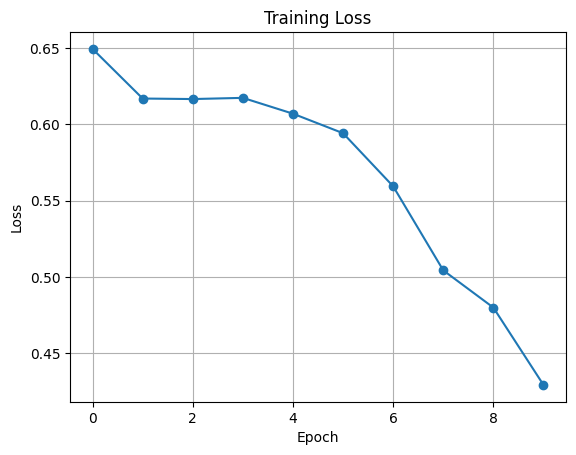

In [50]:
plt.plot(train_losses, marker='o')
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()


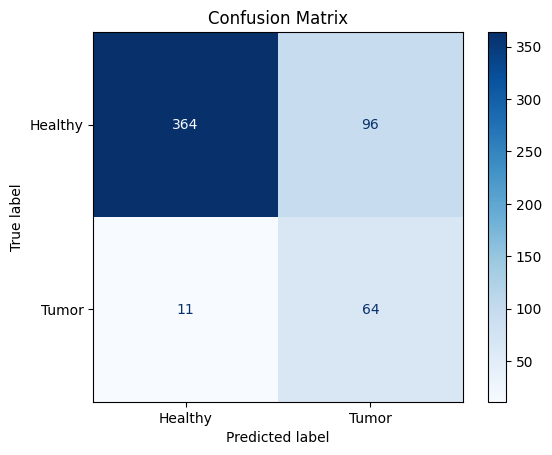

Classification Report:
               precision    recall  f1-score   support

     Healthy       0.97      0.79      0.87       460
       Tumor       0.40      0.85      0.54        75

    accuracy                           0.80       535
   macro avg       0.69      0.82      0.71       535
weighted avg       0.89      0.80      0.83       535



In [51]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

y_true, y_pred = [], []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_data.classes)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print("Classification Report:\n", classification_report(y_true, y_pred, target_names=train_data.classes))


In [52]:
torch.save(model.state_dict(), "swin_ct_model.pth")
print("✅ Model saved as swin_ct_model.pth")


✅ Model saved as swin_ct_model.pth


In [53]:
# Create model again (same structure)
loaded_model = CustomSwinTransformer(in_channels=3, num_classes=2).to(device)
loaded_model.load_state_dict(torch.load("swin_ct_model.pth"))
loaded_model.eval()
print("✅ Model loaded and ready for inference")


✅ Model loaded and ready for inference


In [54]:
from PIL import Image

def predict_single_image(img_path):
    image = Image.open(img_path).convert("RGB")
    image = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output, 1)
        class_name = train_data.classes[predicted.item()]
        print(f"✅ Predicted class: {class_name}")

# 🔍 Example usage:
predict_single_image(r"C:\Users\Divya Ayush\Idea Projects\Research\CT_dataset_split\train\Tumor\ct_tumor (126).jpg")


✅ Predicted class: Tumor


🔬 Tumor Samples:


c:\Users\Divya Ayush\Idea Projects\Research\.venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Divya Ayush\Idea Projects\Research\.venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


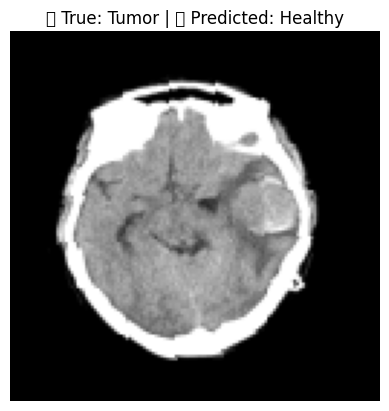

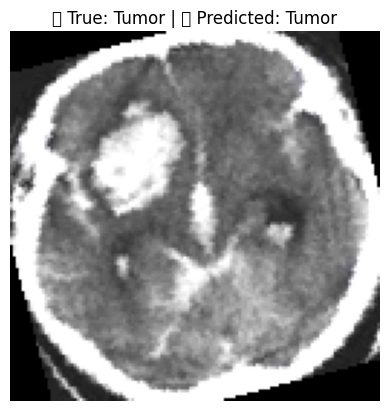

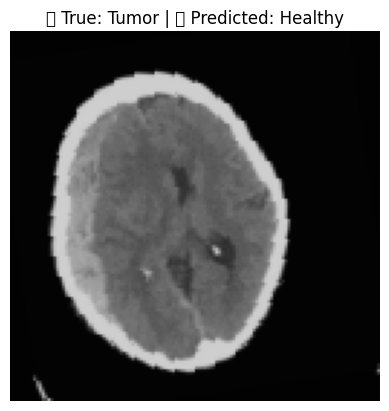

💚 Healthy Samples:


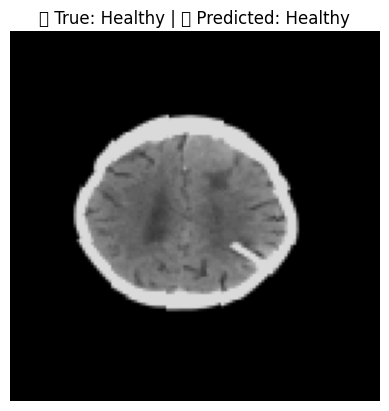

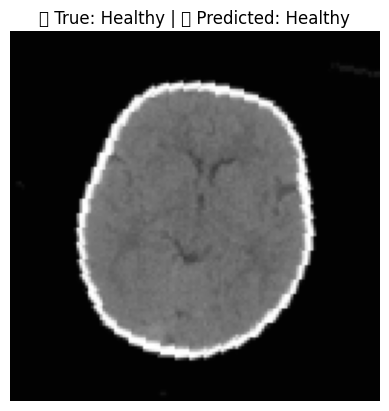

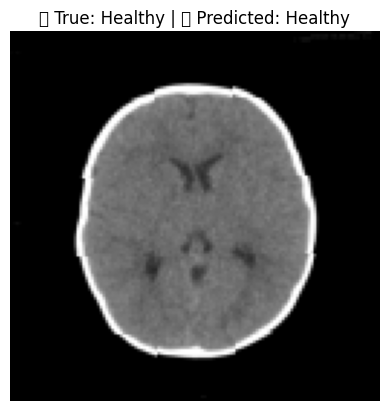

In [55]:
def show_predictions_by_class(class_name='Tumor', n=3):
    model.eval()
    shown = 0
    class_index = train_data.class_to_idx[class_name]

    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images.to(device))
            _, preds = torch.max(outputs, 1)

            for i in range(images.size(0)):
                if labels[i].item() == class_index:
                    img = images[i].permute(1, 2, 0).numpy()
                    true_label = train_data.classes[labels[i]]
                    pred_label = train_data.classes[preds[i].item()]
                    plt.imshow(img)
                    plt.title(f"🧠 True: {true_label} | 🤖 Predicted: {pred_label}")
                    plt.axis('off')
                    plt.show()
                    shown += 1

                if shown >= n:
                    return

# 🔍 Show samples from tumor and healthy
print("🔬 Tumor Samples:")
show_predictions_by_class(class_name='Tumor', n=3)

print("💚 Healthy Samples:")
show_predictions_by_class(class_name='Healthy', n=3)


Fine-Tune Your Already-Trained Model Using Augmented Data

In [56]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ColorJitter(),
    transforms.ToTensor(),
])


In [61]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

dataset = ImageFolder(r'C:\Users\Divya Ayush\Idea Projects\Research\CT_dataset_split\train', transform=transform)
loader = DataLoader(dataset, batch_size=32, shuffle=True)


In [63]:
import torch.nn as nn
from torchvision.models import swin_t, Swin_T_Weights

class MySwinTransformer(nn.Module):
    def __init__(self, num_classes=2):
        super(MySwinTransformer, self).__init__()
        # Load pretrained Swin-Tiny model
        self.backbone = swin_t(weights=Swin_T_Weights.DEFAULT)
        
        # Replace the final classifier head
        in_features = self.backbone.head.in_features
        self.backbone.head = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.backbone(x)


In [64]:
model = MySwinTransformer(num_classes=2)
model.load_state_dict(torch.load('swin_ct_model.pth'))
model.to(device)
model.train()


Downloading: "https://download.pytorch.org/models/swin_t-704ceda3.pth" to C:\Users\Divya Ayush/.cache\torch\hub\checkpoints\swin_t-704ceda3.pth
100%|██████████| 108M/108M [18:10<00:00, 104kB/s]    


RuntimeError: Error(s) in loading state_dict for MySwinTransformer:
	Missing key(s) in state_dict: "backbone.features.0.0.weight", "backbone.features.0.0.bias", "backbone.features.0.2.weight", "backbone.features.0.2.bias", "backbone.features.1.0.norm1.weight", "backbone.features.1.0.norm1.bias", "backbone.features.1.0.attn.relative_position_bias_table", "backbone.features.1.0.attn.relative_position_index", "backbone.features.1.0.attn.qkv.weight", "backbone.features.1.0.attn.qkv.bias", "backbone.features.1.0.attn.proj.weight", "backbone.features.1.0.attn.proj.bias", "backbone.features.1.0.norm2.weight", "backbone.features.1.0.norm2.bias", "backbone.features.1.0.mlp.0.weight", "backbone.features.1.0.mlp.0.bias", "backbone.features.1.0.mlp.3.weight", "backbone.features.1.0.mlp.3.bias", "backbone.features.1.1.norm1.weight", "backbone.features.1.1.norm1.bias", "backbone.features.1.1.attn.relative_position_bias_table", "backbone.features.1.1.attn.relative_position_index", "backbone.features.1.1.attn.qkv.weight", "backbone.features.1.1.attn.qkv.bias", "backbone.features.1.1.attn.proj.weight", "backbone.features.1.1.attn.proj.bias", "backbone.features.1.1.norm2.weight", "backbone.features.1.1.norm2.bias", "backbone.features.1.1.mlp.0.weight", "backbone.features.1.1.mlp.0.bias", "backbone.features.1.1.mlp.3.weight", "backbone.features.1.1.mlp.3.bias", "backbone.features.2.reduction.weight", "backbone.features.2.norm.weight", "backbone.features.2.norm.bias", "backbone.features.3.0.norm1.weight", "backbone.features.3.0.norm1.bias", "backbone.features.3.0.attn.relative_position_bias_table", "backbone.features.3.0.attn.relative_position_index", "backbone.features.3.0.attn.qkv.weight", "backbone.features.3.0.attn.qkv.bias", "backbone.features.3.0.attn.proj.weight", "backbone.features.3.0.attn.proj.bias", "backbone.features.3.0.norm2.weight", "backbone.features.3.0.norm2.bias", "backbone.features.3.0.mlp.0.weight", "backbone.features.3.0.mlp.0.bias", "backbone.features.3.0.mlp.3.weight", "backbone.features.3.0.mlp.3.bias", "backbone.features.3.1.norm1.weight", "backbone.features.3.1.norm1.bias", "backbone.features.3.1.attn.relative_position_bias_table", "backbone.features.3.1.attn.relative_position_index", "backbone.features.3.1.attn.qkv.weight", "backbone.features.3.1.attn.qkv.bias", "backbone.features.3.1.attn.proj.weight", "backbone.features.3.1.attn.proj.bias", "backbone.features.3.1.norm2.weight", "backbone.features.3.1.norm2.bias", "backbone.features.3.1.mlp.0.weight", "backbone.features.3.1.mlp.0.bias", "backbone.features.3.1.mlp.3.weight", "backbone.features.3.1.mlp.3.bias", "backbone.features.4.reduction.weight", "backbone.features.4.norm.weight", "backbone.features.4.norm.bias", "backbone.features.5.0.norm1.weight", "backbone.features.5.0.norm1.bias", "backbone.features.5.0.attn.relative_position_bias_table", "backbone.features.5.0.attn.relative_position_index", "backbone.features.5.0.attn.qkv.weight", "backbone.features.5.0.attn.qkv.bias", "backbone.features.5.0.attn.proj.weight", "backbone.features.5.0.attn.proj.bias", "backbone.features.5.0.norm2.weight", "backbone.features.5.0.norm2.bias", "backbone.features.5.0.mlp.0.weight", "backbone.features.5.0.mlp.0.bias", "backbone.features.5.0.mlp.3.weight", "backbone.features.5.0.mlp.3.bias", "backbone.features.5.1.norm1.weight", "backbone.features.5.1.norm1.bias", "backbone.features.5.1.attn.relative_position_bias_table", "backbone.features.5.1.attn.relative_position_index", "backbone.features.5.1.attn.qkv.weight", "backbone.features.5.1.attn.qkv.bias", "backbone.features.5.1.attn.proj.weight", "backbone.features.5.1.attn.proj.bias", "backbone.features.5.1.norm2.weight", "backbone.features.5.1.norm2.bias", "backbone.features.5.1.mlp.0.weight", "backbone.features.5.1.mlp.0.bias", "backbone.features.5.1.mlp.3.weight", "backbone.features.5.1.mlp.3.bias", "backbone.features.5.2.norm1.weight", "backbone.features.5.2.norm1.bias", "backbone.features.5.2.attn.relative_position_bias_table", "backbone.features.5.2.attn.relative_position_index", "backbone.features.5.2.attn.qkv.weight", "backbone.features.5.2.attn.qkv.bias", "backbone.features.5.2.attn.proj.weight", "backbone.features.5.2.attn.proj.bias", "backbone.features.5.2.norm2.weight", "backbone.features.5.2.norm2.bias", "backbone.features.5.2.mlp.0.weight", "backbone.features.5.2.mlp.0.bias", "backbone.features.5.2.mlp.3.weight", "backbone.features.5.2.mlp.3.bias", "backbone.features.5.3.norm1.weight", "backbone.features.5.3.norm1.bias", "backbone.features.5.3.attn.relative_position_bias_table", "backbone.features.5.3.attn.relative_position_index", "backbone.features.5.3.attn.qkv.weight", "backbone.features.5.3.attn.qkv.bias", "backbone.features.5.3.attn.proj.weight", "backbone.features.5.3.attn.proj.bias", "backbone.features.5.3.norm2.weight", "backbone.features.5.3.norm2.bias", "backbone.features.5.3.mlp.0.weight", "backbone.features.5.3.mlp.0.bias", "backbone.features.5.3.mlp.3.weight", "backbone.features.5.3.mlp.3.bias", "backbone.features.5.4.norm1.weight", "backbone.features.5.4.norm1.bias", "backbone.features.5.4.attn.relative_position_bias_table", "backbone.features.5.4.attn.relative_position_index", "backbone.features.5.4.attn.qkv.weight", "backbone.features.5.4.attn.qkv.bias", "backbone.features.5.4.attn.proj.weight", "backbone.features.5.4.attn.proj.bias", "backbone.features.5.4.norm2.weight", "backbone.features.5.4.norm2.bias", "backbone.features.5.4.mlp.0.weight", "backbone.features.5.4.mlp.0.bias", "backbone.features.5.4.mlp.3.weight", "backbone.features.5.4.mlp.3.bias", "backbone.features.5.5.norm1.weight", "backbone.features.5.5.norm1.bias", "backbone.features.5.5.attn.relative_position_bias_table", "backbone.features.5.5.attn.relative_position_index", "backbone.features.5.5.attn.qkv.weight", "backbone.features.5.5.attn.qkv.bias", "backbone.features.5.5.attn.proj.weight", "backbone.features.5.5.attn.proj.bias", "backbone.features.5.5.norm2.weight", "backbone.features.5.5.norm2.bias", "backbone.features.5.5.mlp.0.weight", "backbone.features.5.5.mlp.0.bias", "backbone.features.5.5.mlp.3.weight", "backbone.features.5.5.mlp.3.bias", "backbone.features.6.reduction.weight", "backbone.features.6.norm.weight", "backbone.features.6.norm.bias", "backbone.features.7.0.norm1.weight", "backbone.features.7.0.norm1.bias", "backbone.features.7.0.attn.relative_position_bias_table", "backbone.features.7.0.attn.relative_position_index", "backbone.features.7.0.attn.qkv.weight", "backbone.features.7.0.attn.qkv.bias", "backbone.features.7.0.attn.proj.weight", "backbone.features.7.0.attn.proj.bias", "backbone.features.7.0.norm2.weight", "backbone.features.7.0.norm2.bias", "backbone.features.7.0.mlp.0.weight", "backbone.features.7.0.mlp.0.bias", "backbone.features.7.0.mlp.3.weight", "backbone.features.7.0.mlp.3.bias", "backbone.features.7.1.norm1.weight", "backbone.features.7.1.norm1.bias", "backbone.features.7.1.attn.relative_position_bias_table", "backbone.features.7.1.attn.relative_position_index", "backbone.features.7.1.attn.qkv.weight", "backbone.features.7.1.attn.qkv.bias", "backbone.features.7.1.attn.proj.weight", "backbone.features.7.1.attn.proj.bias", "backbone.features.7.1.norm2.weight", "backbone.features.7.1.norm2.bias", "backbone.features.7.1.mlp.0.weight", "backbone.features.7.1.mlp.0.bias", "backbone.features.7.1.mlp.3.weight", "backbone.features.7.1.mlp.3.bias", "backbone.norm.weight", "backbone.norm.bias", "backbone.head.weight", "backbone.head.bias". 
	Unexpected key(s) in state_dict: "patch_embed.proj.weight", "patch_embed.proj.bias", "block1.norm1.weight", "block1.norm1.bias", "block1.attn.in_proj_weight", "block1.attn.in_proj_bias", "block1.attn.out_proj.weight", "block1.attn.out_proj.bias", "block1.norm2.weight", "block1.norm2.bias", "block1.mlp.fc1.weight", "block1.mlp.fc1.bias", "block1.mlp.fc2.weight", "block1.mlp.fc2.bias", "block2.norm1.weight", "block2.norm1.bias", "block2.attn.in_proj_weight", "block2.attn.in_proj_bias", "block2.attn.out_proj.weight", "block2.attn.out_proj.bias", "block2.norm2.weight", "block2.norm2.bias", "block2.mlp.fc1.weight", "block2.mlp.fc1.bias", "block2.mlp.fc2.weight", "block2.mlp.fc2.bias", "classifier.weight", "classifier.bias". 

In [66]:
import torch
import torch.nn as nn
from swin_transformer import SwinTransformer

class MySwinTransformer(nn.Module):
    def __init__(self, num_classes=2):
        super(MySwinTransformer, self).__init__()
        self.backbone = SwinTransformer(num_classes=num_classes)

    def forward(self, x):
        return self.backbone(x)

# Ensure to load the model into the correct device (CPU/GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate your model
model = MySwinTransformer(num_classes=2)

# Load weights from your trained model
model.load_state_dict(torch.load('swin_ct_model.pth', map_location=device))

# Move model to device
model.to(device)

# Set to evaluation mode if you're doing inference
model.eval()



ModuleNotFoundError: No module named 'swin_transformer'

In [67]:
import torch.optim as optim
import torch.nn as nn

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5)  # Lower LR for fine-tuning

for epoch in range(5):
    running_loss = 0.0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch [{epoch+1}] Loss: {running_loss:.4f}")


RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same